# The stacked model by blade zones

In [3]:
import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GroupKFold, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from math import sqrt

from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb

import pickle

matplotlib.rcParams['axes.labelsize'] = 14
%matplotlib inline

__Notice:__ In `sklearn` Polynomial Regression is defined indirectly.
First, you have to obtain polynomial features to linearaze data and then fit with vanilla `LinearRegression`
```python
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y_train)
```
  

In [4]:
from surrogate_model import *

In [5]:
# Import the datasets
data_zone1 = pd.read_csv('./datasets/by_zone/Results_3079.csv')
data_zone2 = pd.read_csv('./datasets/by_zone/Results_32434.csv')
data_zone3 = pd.read_csv('./datasets/by_zone/Results_36302.csv')
data_zone4 = pd.read_csv('./datasets/by_zone/Results_37227.csv')
data_zone5 = pd.read_csv('./datasets/by_zone/Results_94936.csv')

In [6]:
# Initialize models for each zone
surrogate_blade_zone1 = surrogate_model(data_zone1)
surrogate_blade_zone2 = surrogate_model(data_zone2)
surrogate_blade_zone3 = surrogate_model(data_zone3)
surrogate_blade_zone4 = surrogate_model(data_zone4)
surrogate_blade_zone5 = surrogate_model(data_zone5)

In [7]:
surrogate_blade_zone1.train(data_size_multipl_by=100)
pickle.dump(surrogate_blade_zone1, open('surrogate_blade_zone1.pkl', 'wb'))
# surrogate_blade_zone1 = pickle.load(open('surrogate_blade_zone1.pkl', 'rb'))

In [8]:
surrogate_blade_zone2.train(data_size_multipl_by=100)
pickle.dump(surrogate_blade_zone2, open('surrogate_blade_zone2.pkl', 'wb'))
# surrogate_blade_zone2 = pickle.load(open('surrogate_blade_zone2.pkl', 'rb'))

In [9]:
surrogate_blade_zone3.train(data_size_multipl_by=100)
pickle.dump(surrogate_blade_zone3, open('surrogate_blade_zone3.pkl', 'wb'))
# surrogate_blade_zone3 = pickle.load(open('surrogate_blade_zone3.pkl', 'rb'))

In [10]:
surrogate_blade_zone4.train(data_size_multipl_by=100)
pickle.dump(surrogate_blade_zone4, open('surrogate_blade_zone4.pkl', 'wb'))
# surrogate_blade_zone4 = pickle.load(open('surrogate_blade_zone4.pkl', 'rb'))

In [11]:
surrogate_blade_zone5.train(data_size_multipl_by=100)
pickle.dump(surrogate_blade_zone5, open('surrogate_blade_zone5.pkl', 'wb'))
# surrogate_blade_zone5 = pickle.load(open('surrogate_blade_zone5.pkl', 'rb'))

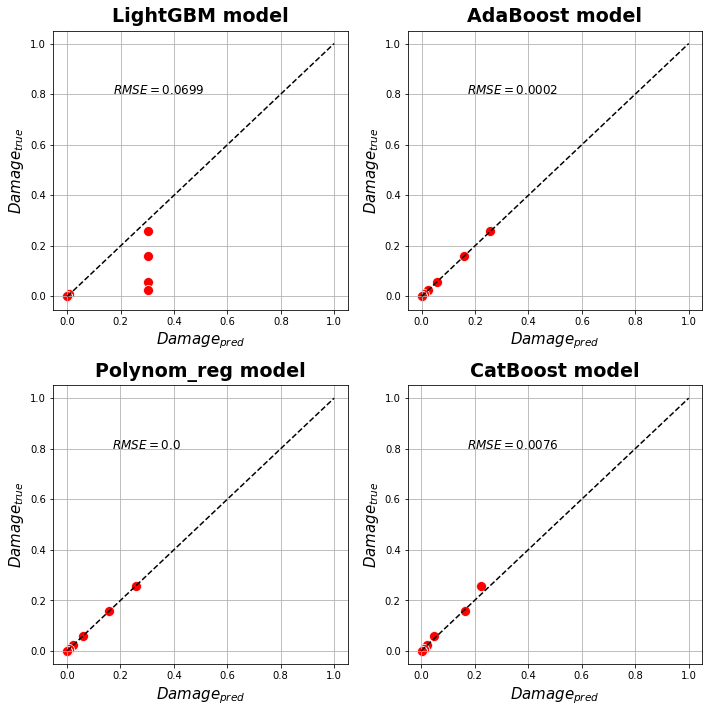

In [31]:
data_features = a.data.loc[:, ['Tg', 'Tk', 'n']]
data_features = a.scaler_features.transform(data_features)
# Make inference
model1_preds = a.lightgbm_model.predict(data_features)
model2_preds = a.adaboost_model.predict(data_features)
model3_preds = a.polynom_reg_model.predict(data_features)
model4_preds = a.catboost_model.predict(data_features)

models_preds = pd.concat([pd.DataFrame(model1_preds), pd.DataFrame(model2_preds), 
                          pd.DataFrame(model3_preds), pd.DataFrame(model4_preds)], axis = 1)
models_preds.columns = ['lightgbm_model', 'adaboost', 'polynom_reg', 'catboost']

damage_pred_scaled = a.strong_model.predict(models_preds)
damage_pred_scaled = damage_pred_scaled.reshape(-1, 1)
damage_pred = a.scaler_target.inverse_transform(damage_pred_scaled)


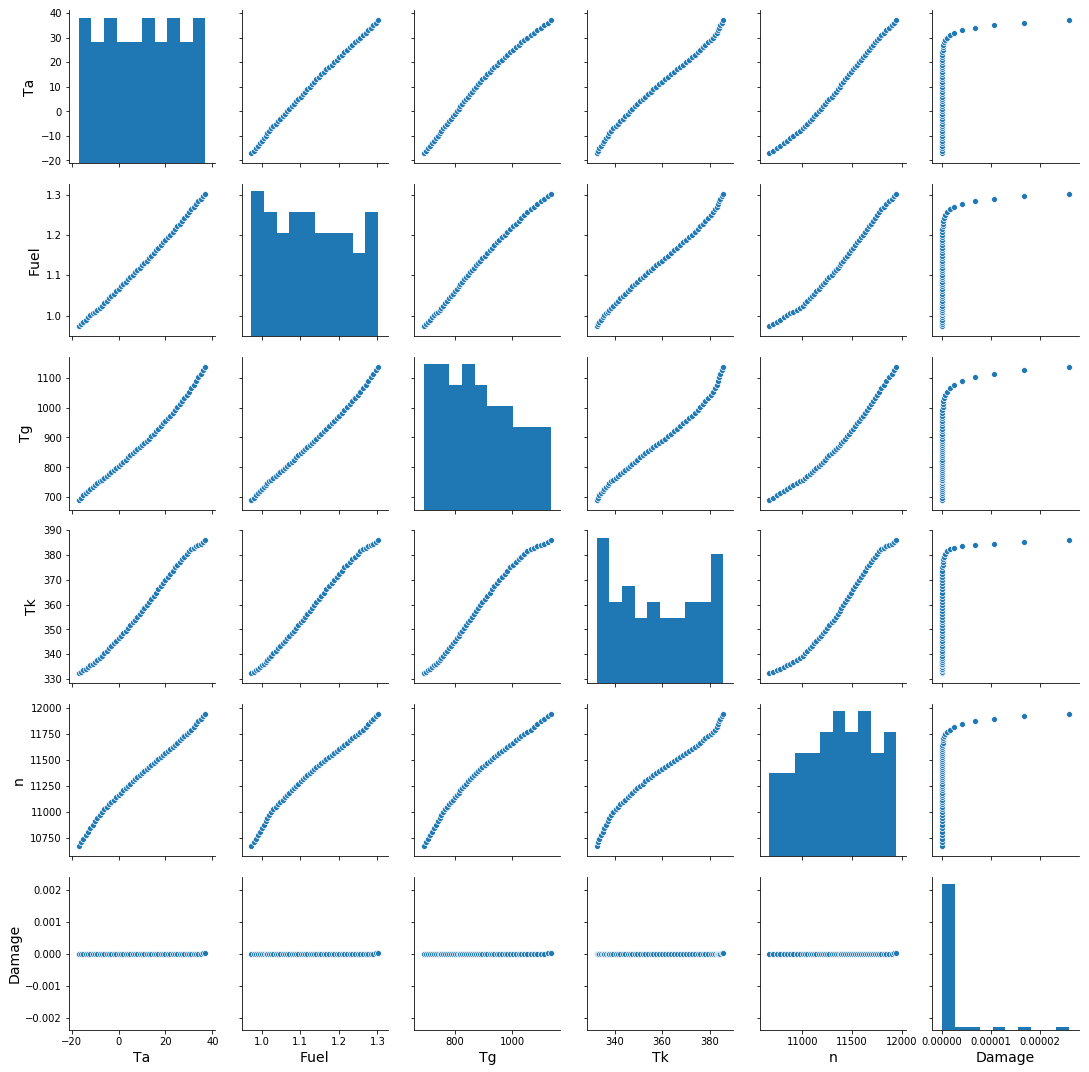

In [3]:
# Basic EDA
sns.pairplot(data1)

Since most of the `damage` values are near 0 (usual working conditions), but we want a good accuracy for extreme values too, lets split the dataset into 2 groups: 
__working__ and __extreme conditions__, and will sample them equally with `resample` (bootstraping by groups)

In [3]:
# Define split variable
split_val = 0.1
data['groups'] = [1 if f > split_val else 0 for f in data.damage]

In [4]:
# Bootstraping by groups (equal sampling)
n_samples = data.shape[0] * 3
data_resampled = resample(data, n_samples = n_samples, stratify = data.groups)

In [329]:
# Normalization
scaler = MinMaxScaler()
scaler.fit(data_resampled)

pickle.dump(scaler, open('scaler.pkl', 'wb')) # save fitted scaler
# scaler = pickle.load(open('scaler.pkl', 'rb')) # load it back

data_scaled = scaler.transform(data_resampled)
data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
data_scaled['groups'] = data_scaled['groups'].astype('int')

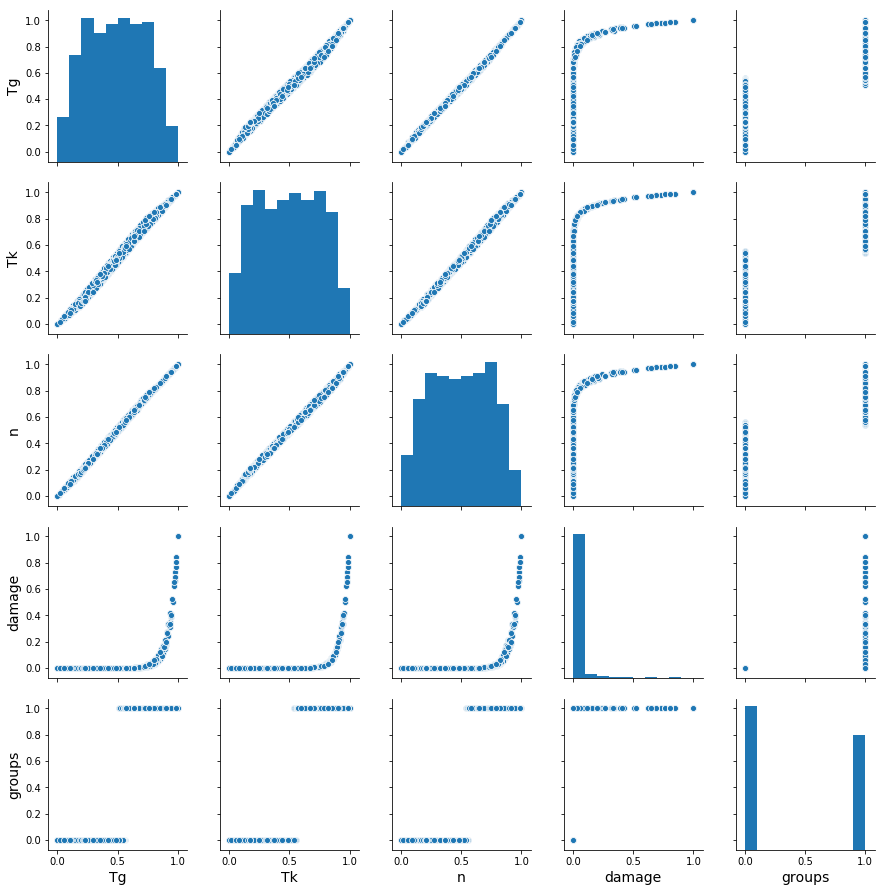

In [330]:
sns.pairplot(data_scaled)

In [331]:
X_train, X_test, y_train, y_test = train_test_split(data_scaled.loc[:, ['Tg', 'Tk', 'n']], data_scaled['damage'], test_size=0.2, random_state=42)

In [332]:
# Define function for CV for "weak" models
def Stacking(model, train, y, test, n_fold, with_eval_set = False):
    folds = KFold(n_splits = n_fold, random_state = 42)
    test_pred = np.empty((0, 1), float)
    train_pred = np.empty((0, 1), float)
    for train_indices, val_indices in folds.split(train, y.values):
        x_train, x_val = train.iloc[train_indices], train.iloc[val_indices]
        y_train, y_val = y.iloc[train_indices], y.iloc[val_indices]

        if with_eval_set == False:
            model.fit(x_train, y_train)
        else:
            model.fit(X = x_train, y = y_train, eval_set = [(x_val, y_val)], verbose = 0)
            
        train_pred = np.append(train_pred, model.predict(x_val))
        
    test_pred = np.append(test_pred, model.predict(test))
    return pd.DataFrame(test_pred), pd.DataFrame(train_pred), model

In [333]:
# Define lightGBM model
model0 = LGBMRegressor(boosting_type = 'gbdt',
                       metric = 'rmse',
                       n_estimators = 1000,
                       num_boost_round = 1000,
                       early_stopping_rounds = 100,
                       # device = 'gpu',
                       n_jobs = -1,
                       random_state = 42,
                       verbose = -1,
                       verbose_eval = False)

# Create the random grid
model0_param_grid = {'learning_rate': [x for x in np.linspace(0.001, 0.05, num = 5)],
                     'max_depth': [int(x) for x in np.linspace(2, 8, num = 4)]}

model0_rs = RandomizedSearchCV(estimator = model0,
                               param_distributions = model0_param_grid,
                               n_iter=10, cv=3, verbose=0)

In [334]:
# # Define RandomForest model
# model0 = RandomForestRegressor(n_estimators = 100,
#                                bootstrap = True,
#                                oob_score = True,
#                                n_jobs = -1,
#                                random_state = 42)

In [335]:
# Define AdaBoost model
model1 = AdaBoostRegressor(base_estimator = RandomForestRegressor(),
                           loss = 'square',
                           n_estimators = 1000,
                           random_state = 42)

# Create the random grid
model1_param_grid = {'learning_rate': [x for x in np.linspace(0.001, 0.05, num = 5)],
                     'base_estimator__max_depth': [int(x) for x in np.linspace(2, 8, num = 4)]}

model1_rs = RandomizedSearchCV(estimator = model1,
                               param_distributions = model1_param_grid,
                               n_iter=10, cv=3, verbose=0)

In [336]:
# Define polynomial regression model
model2 = make_pipeline(PolynomialFeatures(),
                       LinearRegression(n_jobs = -1))

model2_param_grid = {'polynomialfeatures__degree': [2, 3, 4, 5]}

model2_rs = RandomizedSearchCV(estimator = model2,
                               param_distributions = model2_param_grid,
                               n_iter=10, cv=3, verbose=0)

In [337]:
# Define CatBoost model
model3 = CatBoostRegressor(loss_function='RMSE',
                           random_seed = 42,
                           task_type = 'GPU',
                           # boosting_type = 'Plain', # set if it exceeds RAM
                           # params for early stopping:
                           iterations = 1000,
                           od_type = 'Iter',
                           od_wait = 100,
                           silent = True)

# Create the random grid
model3_param_grid = {'learning_rate': [x for x in np.linspace(0.001, 0.05, num = 5)],
                     'depth': [int(x) for x in np.linspace(2, 8, num = 4)]}

model3_rs = RandomizedSearchCV(estimator = model3,
                               param_distributions = model3_param_grid,
                               n_iter=10, cv=3, verbose=0)

In [338]:
# Train "weak" models
kwargs = {'n_fold': 10, 'train': X_train, 'test': X_test, 'y': y_train}

test_pred0, train_pred0, lightgbm_model = Stacking(model = model0, with_eval_set = True, **kwargs)
# pickle.dump(lightgbm_model, open('lightgbm_model.pkl', 'wb'))

test_pred1, train_pred1, adaboost_model = Stacking(model = model1_rs, **kwargs)
# pickle.dump(adaboost_model, open('adaboost_model.pkl', 'wb'))

test_pred2, train_pred2, polynom_reg_model = Stacking(model = model2_rs, **kwargs)
# pickle.dump(polynom_reg_model, open('polynom_reg_model.pkl', 'wb'))

test_pred3, train_pred3, catboost_model = Stacking(model = model3_rs, with_eval_set = True, **kwargs)
# pickle.dump(catboost_model, open('catboost_model.pkl', 'wb'))

In [339]:
# Create "strong" model over "weak" predictions
train_preds = pd.concat([train_pred0, train_pred1, train_pred2, train_pred3], axis = 1)
test_preds = pd.concat([test_pred0, test_pred1, test_pred2, test_pred3], axis = 1)
train_preds.columns = ['lightgbm_model', 'adaboost', 'polynom_reg', 'catboost']
test_preds.columns = ['lightgbm_model', 'adaboost', 'polynom_reg', 'catboost']

strong_model = xgb.XGBRegressor(eval_metric = "rmse",
                                # min_child_weight=1.5,                                                                  
                                # reg_alpha=0.75,
                                # reg_lambda=0.45,
                                objective='reg:squarederror',
                                n_estimators = 1000,
                                num_boost_round = 1000,
                                early_stopping_rounds = 100,
                                # max_depth = 2,
                                # num_leaves = 4,
                                eval_set = [(X_test, y_test)],
                                kvargs = {'tree_method':'gpu_hist'}, # enable GPU
                                seed = 42)

# Create the random grid
strong_model_param_grid = {'colsample_bytree': [0.4, 0.6, 0.8],
                           'reg_lambda': [0.01, 0.5, 1],
                           'learning_rate': [x for x in np.linspace(0.001, 0.05, num = 5)],
                           'max_depth': [int(x) for x in np.linspace(2, 8, num = 4)],
                           'num_leaves': [20, 40, 60, 80]}


strong_model = RandomizedSearchCV(estimator = strong_model,
                                  param_distributions = strong_model_param_grid,
                                  n_iter=100, cv=3, verbose=0)

strong_model.fit(train_preds, y_train)
# pickle.dump(strong_model, open('xgbr_strong_model.pkl', 'wb')) # save the fitted model

y_pred_test = strong_model.predict(test_preds)
print(f"RMSE score for stacked model: {sqrt(mean_squared_error(y_pred_test, y_test))}")

RMSE score for stacked model: 0.0009052603756906132


In [340]:
y_pred_test = strong_model.predict(test_preds)
print(f"RMSE score for stacked model: {sqrt(mean_squared_error(y_pred_test, y_test))}")
print(f"RMSE score for LightGBM model: {sqrt(mean_squared_error(test_pred0, y_test))}")
print(f"RMSE score for AdaBoost model: {sqrt(mean_squared_error(test_pred1, y_test))}")
print(f"RMSE score for polynimial regression: {sqrt(mean_squared_error(test_pred2, y_test))}")
print(f"RMSE score for CatBoost model: {sqrt(mean_squared_error(test_pred3, y_test))}")

RMSE score for stacked model: 0.0009052603756906132
RMSE score for LightGBM model: 0.012030017903305844
RMSE score for AdaBoost model: 0.0006192848001356577
RMSE score for polynimial regression: 0.006991856066514724
RMSE score for CatBoost model: 0.012473316848840706


In [321]:
y_pred_test = strong_model.predict(test_preds)
print(f"RMSE score for stacked model: {sqrt(mean_squared_error(y_pred_test, y_test))}")
print(f"RMSE score for LightGBM model: {sqrt(mean_squared_error(test_pred0, y_test))}")
print(f"RMSE score for AdaBoost model: {sqrt(mean_squared_error(test_pred1, y_test))}")
print(f"RMSE score for polynimial regression: {sqrt(mean_squared_error(test_pred2, y_test))}")
print(f"RMSE score for CatBoost model: {sqrt(mean_squared_error(test_pred3, y_test))}")

RMSE score for stacked model: 0.0006769867078193512
RMSE score for LightGBM model: 0.0088917921494916
RMSE score for AdaBoost model: 0.0008210242015147392
RMSE score for polynimial regression: 0.005867663762123875
RMSE score for CatBoost model: 0.011301488462533735


Visualize the result metrics

In [322]:
def plot_true_vs_pred(y_pred, y_test, title_text, ax=None, **kwargs):
    ax = ax or plt.gca()

    ax.set_title(title_text, y=1.01, fontsize=19, fontweight='bold')
    sns.scatterplot(x = y_pred, y = y_test, ax=ax, color='red', s=100)
    ax.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color='black', linestyle='dashed')
    
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    ax.text(0.17, 0.8, f'$RMSE={round(rmse, 4)}$', fontsize=12, fontweight='bold')
    ax.set_ylabel('$Damage_{true}$', fontsize = 15)
    ax.set_xlabel('$Damage_{pred}$', fontsize = 15)
    ax.grid()

In [323]:
def plot_true_minus_pred(y_pred, y_test, title_text, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    ax.set_title(title_text, y=1.01, fontsize = 20, fontweight='bold')
    sns.distplot((y_test - y_pred), kde=True, norm_hist=True, color='red')

    rmse = sqrt(mean_squared_error(y_test, y_pred))
    ax.text(-0.015, 1350, f'$RMSE={round(rmse, 4)}$', fontsize=12, fontweight='bold')

    ax.set_ylabel('$Occurence$', fontsize = 15)
    ax.set_xlabel('$Damage_{true}$ - $Damage_{pred}$', fontsize = 15)
    ax.grid()

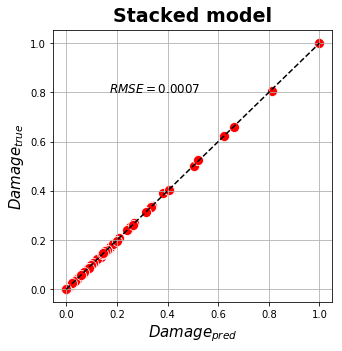

In [324]:
plt.figure(figsize = (5, 5))
plot_true_vs_pred(y_pred_test, y_test, "Stacked model")

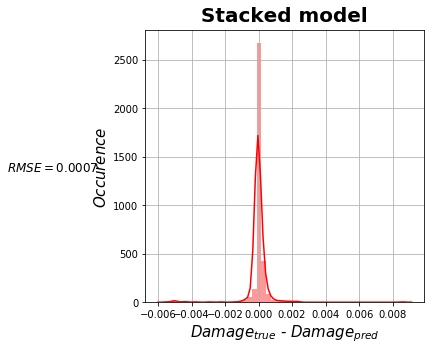

In [325]:
plt.figure(figsize = (5, 5))
plot_true_minus_pred(y_pred_test, y_test, 'Stacked model')

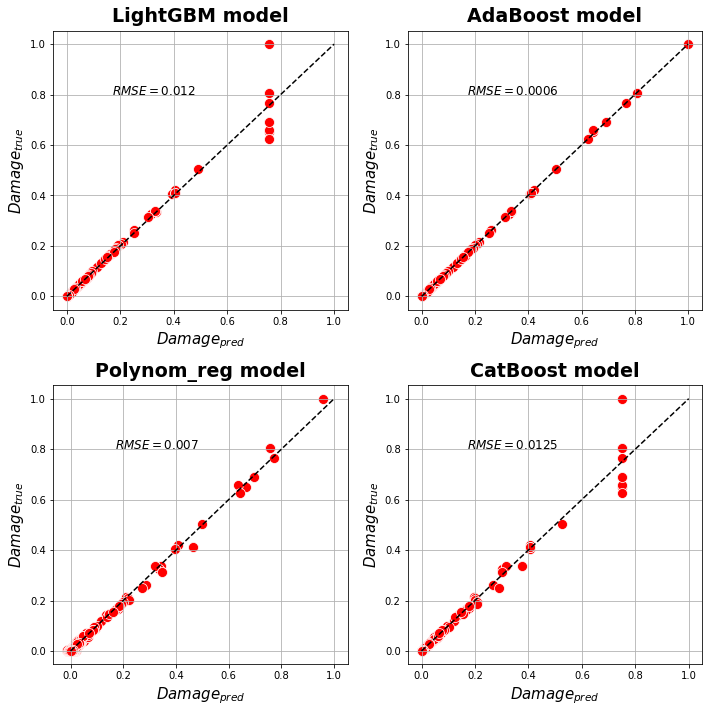

In [341]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()

# plot_true_vs_pred(y_pred_test, y_test, 'Stacked model', ax=axes[0])

plot_true_vs_pred(test_pred0.values.flatten(), y_test, 'LightGBM model', ax=axes[0])
plot_true_vs_pred(test_pred1.values.flatten(), y_test, 'AdaBoost model', ax=axes[1])
plot_true_vs_pred(test_pred2.values.flatten(), y_test, 'Polynom_reg model', ax=axes[2])
plot_true_vs_pred(test_pred3.values.flatten(), y_test, 'CatBoost model', ax=axes[3])
    
fig.tight_layout()
fig.show()

## How to re-use the pre-trained model

In [ ]:
# Import the new dataset
data = pd.read_csv('Data_training.csv', index_col = 0)
data.columns = ['Tg', 'Tk', 'n', 'damage']

# Define group variable
split_val = 0.1
data['groups'] = [1 if f > split_val else 0 for f in data.damage]

# Normalize the data
scaler = pickle.load(open('scaler.pkl', 'rb'))
data_scaled = scaler.transform(data)
data_scaled = pd.DataFrame(data_scaled, columns = data.columns)

# Make inference
x = data_scaled.loc[:, ['Tg', 'Tk', 'n']]
y_true = data['damage']

model1 = pickle.load(open('lightgbm_model.pkl', 'rb'))
model2 = pickle.load(open('polynom_reg_model.pkl', 'rb'))
model3 = pickle.load(open('catboost_model.pkl', 'rb'))
strong_model = pickle.load(open('xgbr_strong_model.pkl', 'rb'))

model1_preds = model1.predict(x)
model2_preds = model2.predict(x)
model3_preds = model3.predict(x)

models_preds = pd.concat([model1_preds, model2_preds, model3_preds], axis = 1)

y_pred = strong_model.predict(models_preds)
print(f"RMSE score for stacked model: {sqrt(mean_squared_error(y_pred, y_true))}")

For example

In [ ]:
# Import the new data_interset
data_inter = pd.read_csv('/home/mraevsky/Skoltech/Surrogate_modeling/ciam_ml_model/Data_training_2.csv', index_col = 0)
data_inter.columns = ['Tg', 'Tk', 'n', 'damage']

# Define pseudo_group column
split_val = 0.1
data_inter['groups'] = [1 if f > split_val else 0 for f in data_inter.damage]

# Normalize the data_inter
scaler = pickle.load(open('../ciam_ml_model/scaler.pkl', 'rb'))
data_inter_scaled = scaler.transform(data_inter)
data_inter_scaled = pd.DataFrame(data_inter_scaled, columns = data_inter.columns)

# Make inference
x = data_inter_scaled.loc[:, ['Tg', 'Tk', 'n']]

model1 = pickle.load(open('../ciam_ml_model/lightgbm_model.pkl', 'rb'))
model2 = pickle.load(open('../ciam_ml_model/adaboost_model.pkl', 'rb'))
model3 = pickle.load(open('../ciam_ml_model/polynom_reg_model.pkl', 'rb'))
model4 = pickle.load(open('../ciam_ml_model/catboost_model.pkl', 'rb'))
strong_model = pickle.load(open('../ciam_ml_model/xgbr_strong_model.pkl', 'rb'))

model1_preds = model1.predict(x)
model2_preds = model2.predict(x)
model3_preds = model3.predict(x)
model4_preds = model4.predict(x)

models_preds = pd.concat([pd.DataFrame(model1_preds), 
                          pd.DataFrame(model2_preds), 
                          pd.DataFrame(model3_preds), 
                          pd.DataFrame(model4_preds)], axis = 1)
models_preds.columns = ['lightgbm_model', 'adaboost', 'polynom_reg', 'catboost']

y_pred = strong_model.predict(models_preds)

# Rescale data back to original scale
data_inter_pred = data_inter_scaled.loc[:, ['Tg', 'Tk', 'n']]
data_inter_pred['damage_pred'] = y_pred
data_inter_pred['groups'] = 0 # pseudo values
data_inter_pred = scaler.inverse_transform(data_inter_pred)
data_inter_pred